In [17]:
import numpy as np
from dataclasses import dataclass
import itertools
from utils.plot_funcs import plot_list_of_curves
from typing import Optional, Mapping, Tuple
from collections import Counter


In [5]:
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)

In [6]:
@dataclass
class Process1:

    @dataclass
    class State:
        price: int
    
    level_param: int # level to which price mean-reverts
    alpha1: float = 0.25 # strength of mean-reversion (non-negative value)

    def up_prob(self, state: State) -> float:
        return 1. / (1 + np.exp(-self.alpha1 * (self.level_param - state.price)))

    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)


def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1= alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(simulation(process, start_state), time_steps + 1)), float)
        for _ in range(num_traces)
    ])

In [7]:

handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}
@dataclass
class Process2:

    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]
    
    alpha2: float = 0.75 # strength of reverse-pull (value in [0,1])

    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])
    
    def next_state(self, state: State) -> float:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(price=state.price + up_move * 2 - 1, is_prev_move_up=bool(up_move))


def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(simulation(process, start_state), time_steps + 1)), float)
        for _ in range(num_traces)
    ])

In [8]:
@dataclass
class Process3:
    
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int
    
    alpha3: float = 1.0 # strength of reverse-pull (non-negative value)

    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        if total == 0:
            return 0.5
        elif state.num_down_moves == 0:
            return state.num_down_moves ** self.alpha3
        else:
            return 1. / (1 + (total / state.num_down_moves - 1) ** self.alpha3)

    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(num_up_moves=state.num_up_moves + up_move, num_down_moves=state.num_down_moves + 1 - up_move)

def process3_price_traces(
    start_price: int,
    alpha3: float,
    time_steps: int, 
    num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves for s in itertools.islice(simulation(process, start_state), time_steps + 1)), float)
        for _ in range(num_traces)
    ])

In [15]:
from operator import itemgetter
from typing import Sequence


def plot_single_trace_all_processes(
    process1_trace: np.ndarray,
    process2_trace: np.ndarray,
    process3_trace: np.ndarray
) -> None:
    traces_len: int = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )

def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs: Sequence[Tuple[int, int]] = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]

def plot_distribution_at_time_all_processes(
    process1_traces: np.ndarray,
    process2_traces: np.ndarray,
    process3_traces: np.ndarray
) -> None:

    num_traces: int = len(process1_traces)
    time_steps: int = len(process1_traces[0]) - 1

    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )

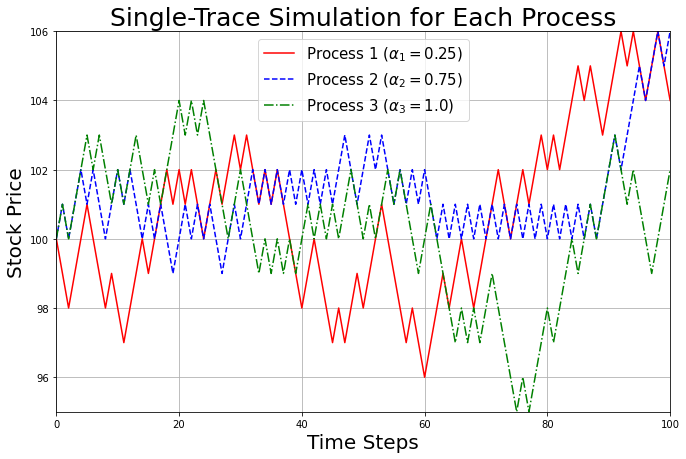

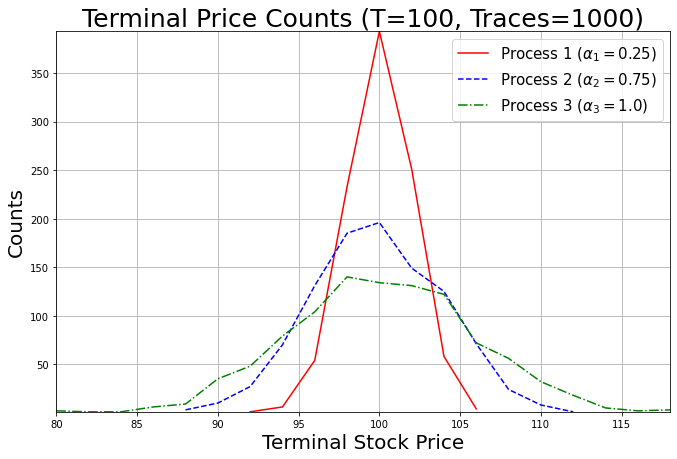

In [18]:
start_price: int = 100
level_param: int = 100
alpha1: float = 0.25
alpha2: float = 0.75
alpha3: float = 1.0
time_steps: int = 100
num_traces: int = 1000

process1_traces: np.ndarray = process1_price_traces(
    start_price=start_price,
    level_param=level_param,
    alpha1=alpha1,
    time_steps=time_steps,
    num_traces=num_traces
)
process2_traces: np.ndarray = process2_price_traces(
    start_price=start_price,
    alpha2=alpha2,
    time_steps=time_steps,
    num_traces=num_traces
)
process3_traces: np.ndarray = process3_price_traces(
    start_price=start_price,
    alpha3=alpha3,
    time_steps=time_steps,
    num_traces=num_traces
)

trace1 = process1_traces[0]
trace2 = process2_traces[0]
trace3 = process3_traces[0]

plot_single_trace_all_processes(trace1, trace2, trace3)

plot_distribution_at_time_all_processes(
    process1_traces,
    process2_traces,
    process3_traces
)